In [ ]:
import json

path = "/content/all_law_final.jsonl"

data = []
with open(path, "r", encoding="utf-8") as f:
    for line in f:
        data.append(json.loads(line.strip()))

print("Total records:", len(data))


Total records: 14000


In [ ]:
!pip install anytree wordcloud -q

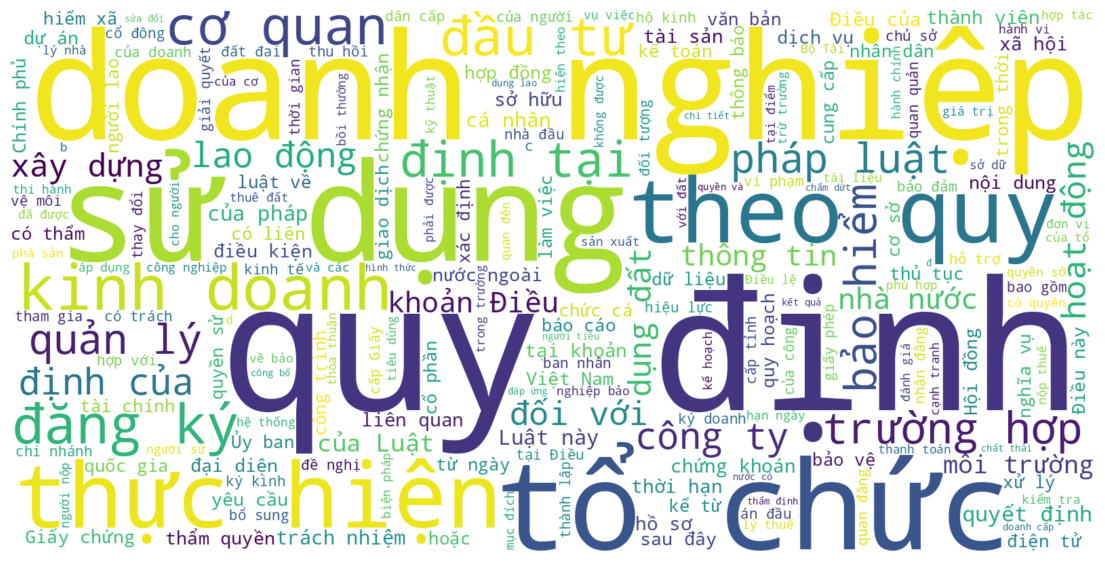

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_text = " ".join([item["clause_text"] for item in data])

wc = WordCloud(
    background_color='white',
    width=1600,
    height=800
).generate(all_text)


plt.figure(figsize=(14, 8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()


✅ Loaded 14000 clauses
✅ Total articles: 258

===== 📊 THỐNG KÊ TỔNG QUAN =====
📌 Số Điều: 258
📌 Điều ngắn nhất (token): 80
📌 Điều dài nhất (token): 36139
📌 Trung bình: 4132.57
📌 Median: 3256.0
📌 Std: 3956.00
📌 Percentile 25%: 1319.25
📌 Percentile 50%: 3256.0
📌 Percentile 75%: 5921.75
📌 Percentile 90%: 8705.6
📌 Percentile 95%: 10141.099999999999
📌 Percentile 99%: 17189.93000000002

===== TOP 20 ĐIỀU DÀI NHẤT (token) =====
1. Điều 66: 36139 tokens
2. Điều 3: 23838 tokens
3. Điều 4: 18644 tokens
4. Điều 30: 16093 tokens
5. Điều 38: 13634 tokens
6. Điều 5: 12377 tokens
7. Điều 28: 12062 tokens
8. Điều 8: 11837 tokens
9. Điều 7: 11204 tokens
10. Điều 27: 10483 tokens
11. Điều 14: 10368 tokens
12. Điều 35: 10244 tokens
13. Điều 26: 10204 tokens
14. Điều 11: 10130 tokens
15. Điều 15: 9884 tokens
16. Điều 10: 9786 tokens
17. Điều 6: 9710 tokens
18. Điều 23: 9258 tokens
19. Điều 20: 9229 tokens
20. Điều 18: 9215 tokens


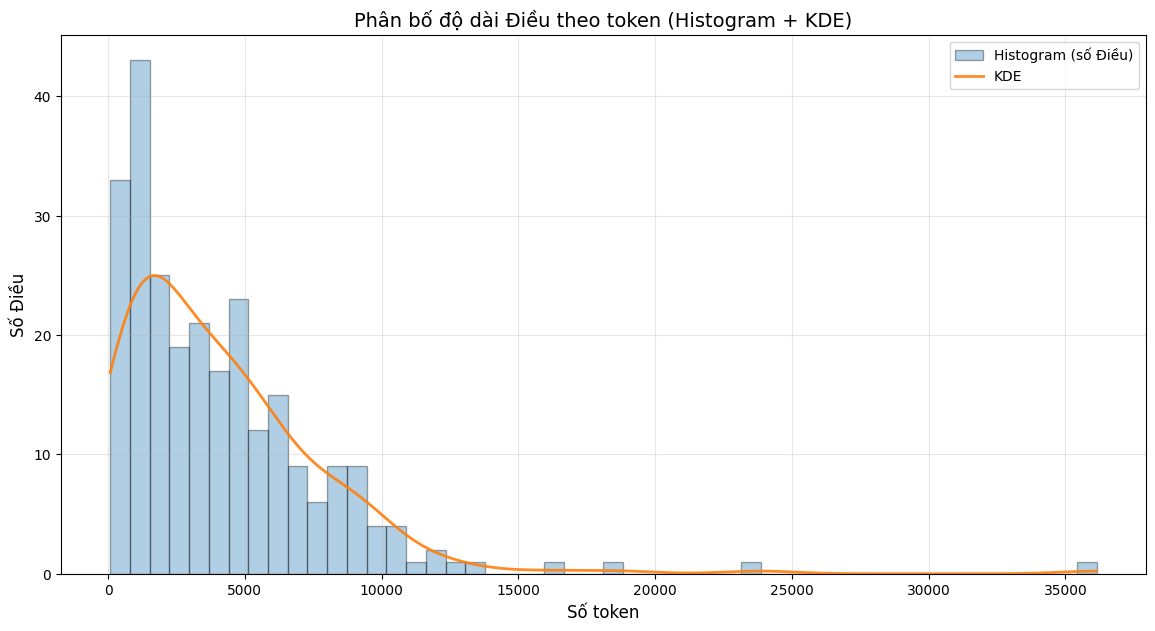

In [ ]:
# =========================================
# 1️⃣ Import thư viện
# =========================================
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from transformers import AutoTokenizer

# =========================================
# 2️⃣ Load JSONL file
# =========================================
jsonl_file = "/content/all_law_final.jsonl"   # ⬅️ sửa path nếu cần

rows = []
with open(jsonl_file, "r", encoding="utf-8") as f:
    for line in f:
        rows.append(json.loads(line))

df = pd.DataFrame(rows)
print(f"✅ Loaded {len(df)} clauses")

# =========================================
# 3️⃣ Gộp tất cả clause_text theo Điều
# =========================================
articles = (
    df.groupby("article_title")["clause_text"]
    .apply(lambda x: "\n".join([str(t) for t in x]))
    .reset_index()
    .rename(columns={"clause_text": "full_article_text"})
)
print(f"✅ Total articles: {len(articles)}")

# =========================================
# 4️⃣ Tokenize bằng tokenizer Vi-Qwen2-3B-RAG
# =========================================
tokenizer = AutoTokenizer.from_pretrained("AITeamVN/Vi-Qwen2-3B-RAG")

def count_tokens(text):
    return len(tokenizer(text, add_special_tokens=False)["input_ids"])

articles["token_count"] = articles["full_article_text"].apply(count_tokens)
articles["char_count"]  = articles["full_article_text"].apply(len)

# =========================================
# 5️⃣ Thống kê cơ bản (in ra màn hình)
# =========================================
data = articles["token_count"].values

print("\n===== 📊 THỐNG KÊ TỔNG QUAN =====")
print(f"📌 Số Điều: {len(articles)}")
print(f"📌 Điều ngắn nhất (token): {data.min()}")
print(f"📌 Điều dài nhất (token): {data.max()}")
print(f"📌 Trung bình: {data.mean():.2f}")
print(f"📌 Median: {np.median(data)}")
print(f"📌 Std: {np.std(data):.2f}")
print(f"📌 Percentile 25%: {np.percentile(data, 25)}")
print(f"📌 Percentile 50%: {np.percentile(data, 50)}")
print(f"📌 Percentile 75%: {np.percentile(data, 75)}")
print(f"📌 Percentile 90%: {np.percentile(data, 90)}")
print(f"📌 Percentile 95%: {np.percentile(data, 95)}")
print(f"📌 Percentile 99%: {np.percentile(data, 99)}")

# Top 20 Điều dài nhất
articles_sorted = articles.sort_values("token_count", ascending=False)
print("\n===== TOP 20 ĐIỀU DÀI NHẤT (token) =====")
for i, row in enumerate(articles_sorted.head(20).itertuples(), 1):
    print(f"{i}. {row.article_title}: {row.token_count} tokens")

# =========================================
# 6️⃣ Histogram + KDE overlay (1 biểu đồ)
# =========================================
kde = gaussian_kde(data)
x_vals = np.linspace(data.min(), data.max(), 500)
y_vals = kde(x_vals)

plt.figure(figsize=(14,7))

# Histogram
counts, bins, patches = plt.hist(
    data,
    bins=50,
    edgecolor="black",
    alpha=0.35,
    label="Histogram (số Điều)"
)

# Scale KDE về cùng đơn vị số Điều
bin_width = bins[1] - bins[0]
plt.plot(
    x_vals,
    y_vals * len(data) * bin_width,
    linewidth=2,
    label="KDE",
    alpha=0.9
)

plt.title("Phân bố độ dài Điều theo token (Histogram + KDE)", fontsize=14)
plt.xlabel("Số token", fontsize=12)
plt.ylabel("Số Điều", fontsize=12)
plt.grid(alpha=0.3)
plt.legend()
plt.show()


✅ Loaded 14000 clauses


,law_title,article_id,article_title,article_link,clause_no,clause_text
0,Bộ luật lao động 2019 số 45/2019/QH14 áp dụng ...,1,Điều 1,https://thuvienphapluat.vn/van-ban/Lao-dong-Ti...,0,Phạm vi điều chỉnh Bộ luật Lao động quy định t...
1,Bộ luật lao động 2019 số 45/2019/QH14 áp dụng ...,2,Điều 2,https://thuvienphapluat.vn/van-ban/Lao-dong-Ti...,0,Đối tượng áp dụng
2,Bộ luật lao động 2019 số 45/2019/QH14 áp dụng ...,2,Điều 2,https://thuvienphapluat.vn/van-ban/Lao-dong-Ti...,1,"1. Người lao động, người học nghề, người tập n..."
3,Bộ luật lao động 2019 số 45/2019/QH14 áp dụng ...,2,Điều 2,https://thuvienphapluat.vn/van-ban/Lao-dong-Ti...,2,2. Người sử dụng lao động.
4,Bộ luật lao động 2019 số 45/2019/QH14 áp dụng ...,2,Điều 2,https://thuvienphapluat.vn/van-ban/Lao-dong-Ti...,3,3. Người lao động nước ngoài làm việc tại Việt...



===== 📊 THỐNG KÊ TỔNG QUAN TRÊN KHOẢN =====
📌 Số khoản: 14000
📌 Khoản ngắn nhất (token): 2
📌 Khoản dài nhất (token): 2000
📌 Trung bình: 75.92
📌 Median: 52.0
📌 Std: 88.05
📌 Percentile 25%: 25.0
📌 Percentile 50%: 52.0
📌 Percentile 75%: 92.0
📌 Percentile 90%: 164.0
📌 Percentile 95%: 232.0
📌 Percentile 99%: 424.0100000000002

===== TOP 20 KHOẢN DÀI NHẤT (token) =====
1. Điều 27 / Khoản 1: 2000 tokens
2. Điều 38 / Khoản 4: 1191 tokens
3. Điều 43 / Khoản 6: 1137 tokens
4. Điều 38 / Khoản 1: 1113 tokens
5. Điều 137 / Khoản 1: 1083 tokens
6. Điều 63 / Khoản 2: 1074 tokens
7. Điều 9 / Khoản 1: 1054 tokens
8. Điều 71 / Khoản 2: 1019 tokens
9. Điều 133 / Khoản 1: 997 tokens
10. Điều 28 / Khoản 1: 989 tokens
11. Điều 42 / Khoản 1: 936 tokens
12. Điều 119 / Khoản 2: 884 tokens
13. Điều 39 / Khoản 3: 875 tokens
14. Điều 74 / Khoản 2: 866 tokens
15. Điều 124 / Khoản 3: 857 tokens
16. Điều 142 / Khoản 2: 854 tokens
17. Điều 109 / Khoản 2: 846 tokens
18. Điều 23 / Khoản 5: 831 tokens
19. Điều 218 / Kh

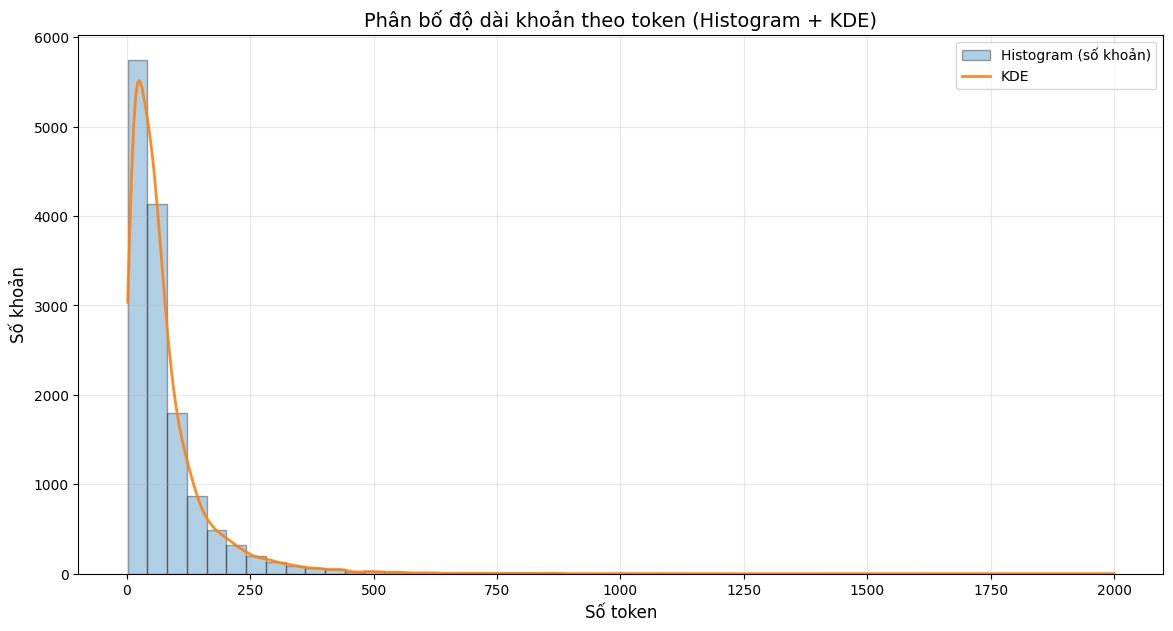

In [ ]:
# =========================================
# 1️⃣ Import thư viện
# =========================================
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from transformers import AutoTokenizer

# =========================================
# 2️⃣ Load JSONL file
# =========================================
jsonl_file = "/content/all_law_final.jsonl"   # ⬅️ sửa path nếu cần

rows = []
with open(jsonl_file, "r", encoding="utf-8") as f:
    for line in f:
        rows.append(json.loads(line))

df = pd.DataFrame(rows)
print(f"✅ Loaded {len(df)} clauses")
display(df.head())

# =========================================
# 3️⃣ Tokenize từng khoản
# =========================================
tokenizer = AutoTokenizer.from_pretrained("AITeamVN/Vi-Qwen2-3B-RAG")

def count_tokens(text):
    return len(tokenizer(text, add_special_tokens=False)["input_ids"])

df["token_count"] = df["clause_text"].apply(count_tokens)
df["char_count"]  = df["clause_text"].apply(len)

# =========================================
# 4️⃣ Thống kê tổng quan trên khoản
# =========================================
data = df["token_count"].values

print("\n===== 📊 THỐNG KÊ TỔNG QUAN TRÊN KHOẢN =====")
print(f"📌 Số khoản: {len(df)}")
print(f"📌 Khoản ngắn nhất (token): {data.min()}")
print(f"📌 Khoản dài nhất (token): {data.max()}")
print(f"📌 Trung bình: {data.mean():.2f}")
print(f"📌 Median: {np.median(data)}")
print(f"📌 Std: {np.std(data):.2f}")
print(f"📌 Percentile 25%: {np.percentile(data, 25)}")
print(f"📌 Percentile 50%: {np.percentile(data, 50)}")
print(f"📌 Percentile 75%: {np.percentile(data, 75)}")
print(f"📌 Percentile 90%: {np.percentile(data, 90)}")
print(f"📌 Percentile 95%: {np.percentile(data, 95)}")
print(f"📌 Percentile 99%: {np.percentile(data, 99)}")

# Top 20 khoản dài nhất
df_sorted = df.sort_values("token_count", ascending=False)
print("\n===== TOP 20 KHOẢN DÀI NHẤT (token) =====")
for i, row in enumerate(df_sorted.head(20).itertuples(), 1):
    print(f"{i}. {row.article_title} / Khoản {row.clause_no}: {row.token_count} tokens")

# =========================================
# 5️⃣ Histogram + KDE overlay (1 biểu đồ)
# =========================================
kde = gaussian_kde(data)
x_vals = np.linspace(data.min(), data.max(), 500)
y_vals = kde(x_vals)

plt.figure(figsize=(14,7))

# Histogram
counts, bins, patches = plt.hist(
    data,
    bins=50,
    edgecolor="black",
    alpha=0.35,
    label="Histogram (số khoản)"
)

# Scale KDE về cùng đơn vị số khoản
bin_width = bins[1] - bins[0]
plt.plot(
    x_vals,
    y_vals * len(data) * bin_width,
    linewidth=2,
    label="KDE",
    alpha=0.9
)

plt.title("Phân bố độ dài khoản theo token (Histogram + KDE)", fontsize=14)
plt.xlabel("Số token", fontsize=12)
plt.ylabel("Số khoản", fontsize=12)
plt.grid(alpha=0.3)
plt.legend()
plt.show()
